# QUESTION 2: University Rankings

## Step A: Data Cleaning
We'll work with the Universities dataset, identify missing values, and remove any rows (records) that contain at least one missing measurement. We'll also report how many rows were removed and save the complete-case dataset locally.

In [2]:
# Imports and dataset loading (dmba provides the Universities.csv dataset)
import pandas as pd
try:
    import dmba
    df = dmba.load_data('Universities.csv')
except Exception as e:
    # Fallback if dmba is unavailable or fails: try local CSV next to this notebook
    import os
    csv_path = os.path.join(os.path.dirname(os.getcwd()), 'DATA MINING', 'Universities.csv')
    if not os.path.exists(csv_path):
        raise FileNotFoundError("Could not load Universities.csv via dmba or from local path. Please place Universities.csv in the DATA MINING folder.")
    df = pd.read_csv(csv_path)
display(df.head())
print(f"Original shape: {df.shape}")

,College Name,State,Public (1)/ Private (2),# appli. rec'd,# appl. accepted,# new stud. enrolled,% new stud. from top 10%,% new stud. from top 25%,# FT undergrad,# PT undergrad,in-state tuition,out-of-state tuition,room,board,add. fees,estim. book costs,estim. personal $,% fac. w/PHD,stud./fac. ratio,Graduation rate
0,Alaska Pacific University,AK,2,193.0,146.0,55.0,16.0,44.0,249.0,869.0,7560.0,7560.0,1620.0,2500.0,130.0,800.0,1500.0,76.0,11.9,15.0
1,University of Alaska at Fairbanks,AK,1,1852.0,1427.0,928.0,NaN,NaN,3885.0,4519.0,1742.0,5226.0,1800.0,1790.0,155.0,650.0,2304.0,67.0,10.0,NaN
2,University of Alaska Southeast,AK,1,146.0,117.0,89.0,4.0,24.0,492.0,1849.0,1742.0,5226.0,2514.0,2250.0,34.0,500.0,1162.0,39.0,9.5,39.0
3,University of Alaska at Anchorage,AK,1,2065.0,1598.0,1162.0,NaN,NaN,6209.0,10537.0,1742.0,5226.0,2600.0,2520.0,114.0,580.0,1260.0,48.0,13.7,NaN
4,Alabama Agri. & Mech. Univ.,AL,1,2817.0,1920.0,984.0,NaN,NaN,3958.0,305.0,1700.0,3400.0,1108.0,1442.0,155.0,500.0,850.0,53.0,14.3,40.0


Original shape: (1302, 20)


In [3]:
# Normalize common missing-value placeholders to proper NaN
import numpy as np
# Some datasets use '?', 'NA', 'N/A', empty strings, or spaces to indicate missing values
missing_tokens = ['?', 'NA', 'N/A', 'na', 'n/a', '', ' ']
df = df.replace(missing_tokens, pd.NA)
# If numeric columns were read as strings due to placeholders, try to coerce them back to numeric
for col in df.columns:
    if df[col].dtype == 'object':
        # Attempt numeric conversion where appropriate; non-numeric will stay as object
        coerced = pd.to_numeric(df[col], errors='ignore')
        df[col] = coerced
total_missing = int(df.isna().sum().sum())
print(f"Total missing values detected: {total_missing}")
df.isna().sum().sort_values(ascending=False).head(10)

Total missing values detected: 2002


C:\Users\Usuario\AppData\Local\Temp\ipykernel_20512\1027624417.py:10: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  coerced = pd.to_numeric(df[col], errors='ignore')


board                       498
room                        321
add. fees                   274
% new stud. from top 10%    235
% new stud. from top 25%    202
estim. personal $           181
Graduation rate              98
estim. book costs            48
% fac. w/PHD                 32
# PT undergrad               32
dtype: int64

In [4]:
# Drop any rows with at least one missing value (complete-case analysis)
df_complete = df.dropna(axis=0, how='any').copy()
dropped = df.shape[0] - df_complete.shape[0]
print(f"New shape after dropping rows with any missing values: {df_complete.shape}")
print(f"Rows removed: {dropped}")

New shape after dropping rows with any missing values: (471, 20)
Rows removed: 831


## Step B: Hierarchical Clustering (Complete Linkage, Euclidean)
We use only continuous (numeric) measurements. First we standardize (z-score) each numeric feature, then perform hierarchical clustering with complete linkage and Euclidean distance. We visualize a dendrogram to inspect a plausible number of clusters, and compute silhouette scores across a range of cluster counts to support the choice.

In [6]:
# Prepare numeric (continuous) features and standardize
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import seaborn as sns
numeric_df = df_complete.select_dtypes(include=[np.number]).copy()
print(f"Numeric feature count: {numeric_df.shape[1]}")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_df)
print(f"Scaled data shape: {X_scaled.shape}")

Numeric feature count: 18
Scaled data shape: (471, 18)


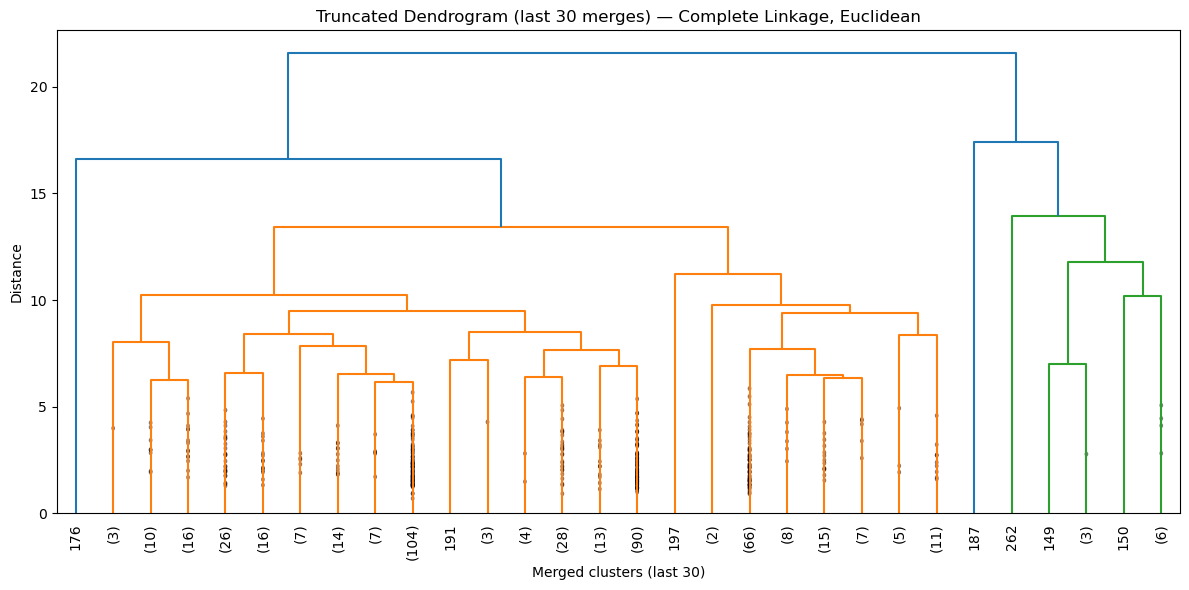

In [7]:
# Hierarchical clustering (complete linkage, Euclidean) and dendrogram
Z = linkage(X_scaled, method='complete', metric='euclidean')
plt.figure(figsize=(12, 6))
plt.title('Truncated Dendrogram (last 30 merges) — Complete Linkage, Euclidean')
dendro = dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=10., show_contracted=True)
plt.xlabel('Merged clusters (last 30)')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

Silhouette scores (k=2..10):
k=2: 0.4964
k=3: 0.4782
k=4: 0.4778
k=5: 0.4479
k=6: 0.2056
k=7: 0.2001
k=8: 0.1983
k=9: 0.1987
k=10: 0.1988
Best k by silhouette: 2


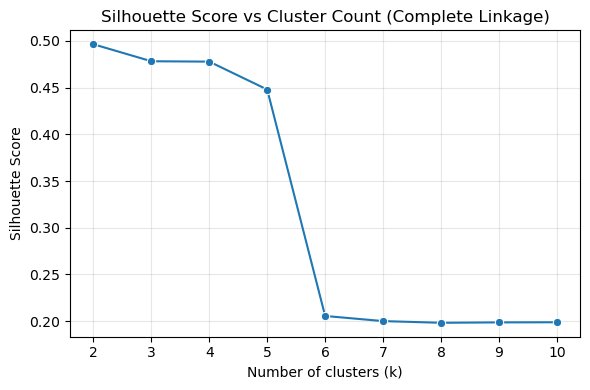

In [8]:
# Silhouette scores for potential cluster counts using AgglomerativeClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
sil_scores = {}
for k in range(2, 11):
    model = AgglomerativeClustering(n_clusters=k, linkage='complete', metric='euclidean')
    labels = model.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores[k] = sil
print('Silhouette scores (k=2..10):')
for k, s in sil_scores.items():
    print(f"k={k}: {s:.4f}")
best_k = max(sil_scores, key=sil_scores.get)
print(f"Best k by silhouette: {best_k}")
plt.figure(figsize=(6,4))
sns.lineplot(x=list(sil_scores.keys()), y=list(sil_scores.values()), marker='o')
plt.title('Silhouette Score vs Cluster Count (Complete Linkage)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(range(2,11))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### How many clusters?
From the dendrogram, a clear jump in linkage distance occurs around ~16–18, suggesting a horizontal cut there that yields approximately 3 clusters. As a quantitative check, the silhouette scores peak at k=2 (≈0.50) but are very close for k=3–4 (≈0.48).
Conclusion: Based on the dendrogram, 3 clusters is a reasonable choice for this dataset. If we prioritize compactness/separation, k=2 is the best by silhouette; both k=2 and k=3 are defensible depending on the downstream goal.

## Step C: Cluster Characterization
We fix k=3 (dendrogram-driven choice) and describe each cluster using numeric feature summaries (mean & median) and standardized profiles. We'll highlight distinguishing high/low features to form contextual descriptions.

In [10]:
# Attach k=3 cluster labels
from sklearn.cluster import AgglomerativeClustering
k3_model = AgglomerativeClustering(n_clusters=3, linkage='complete', metric='euclidean')
k3_labels = k3_model.fit_predict(X_scaled)
df_complete = df_complete.copy()
df_complete['cluster'] = k3_labels
print(df_complete['cluster'].value_counts().sort_index())

cluster
0    458
1     12
2      1
Name: count, dtype: int64


In [11]:
# Summary statistics (mean & median) per cluster
numeric_cols = df_complete.select_dtypes(include=['number']).columns.difference(['cluster'])
cluster_means = df_complete.groupby('cluster')[numeric_cols].mean()
cluster_medians = df_complete.groupby('cluster')[numeric_cols].median()
print('Cluster sizes:')
print(df_complete['cluster'].value_counts().sort_index())
print('\nCluster means (first 8 cols):')
display(cluster_means.iloc[:, :8].round(2))
print('\nCluster medians (first 8 cols):')
display(cluster_medians.iloc[:, :8].round(2))

Cluster sizes:
cluster
0    458
1     12
2      1
Name: count, dtype: int64

Cluster means (first 8 cols):


,# FT undergrad,# PT undergrad,# appl. accepted,# appli. rec'd,# new stud. enrolled,% fac. w/PHD,% new stud. from top 10%,% new stud. from top 25%
cluster,,,,,,,,
0,3078.83,684.05,1790.03,2747.43,683.45,72.86,27.81,55.27
1,20961.58,3372.42,12118.50,17750.33,4263.92,85.17,35.92,70.25
2,16502.00,21836.00,6397.00,11054.00,3524.00,88.00,26.00,55.00



Cluster medians (first 8 cols):


,# FT undergrad,# PT undergrad,# appl. accepted,# appli. rec'd,# new stud. enrolled,% fac. w/PHD,% new stud. from top 10%,% new stud. from top 25%
cluster,,,,,,,,
0,1691.5,286.5,1106.5,1559.0,431.0,75.0,23.0,53.5
1,21532.5,2955.5,11085.5,14613.0,4168.0,88.5,40.5,75.0
2,16502.0,21836.0,6397.0,11054.0,3524.0,88.0,26.0,55.0


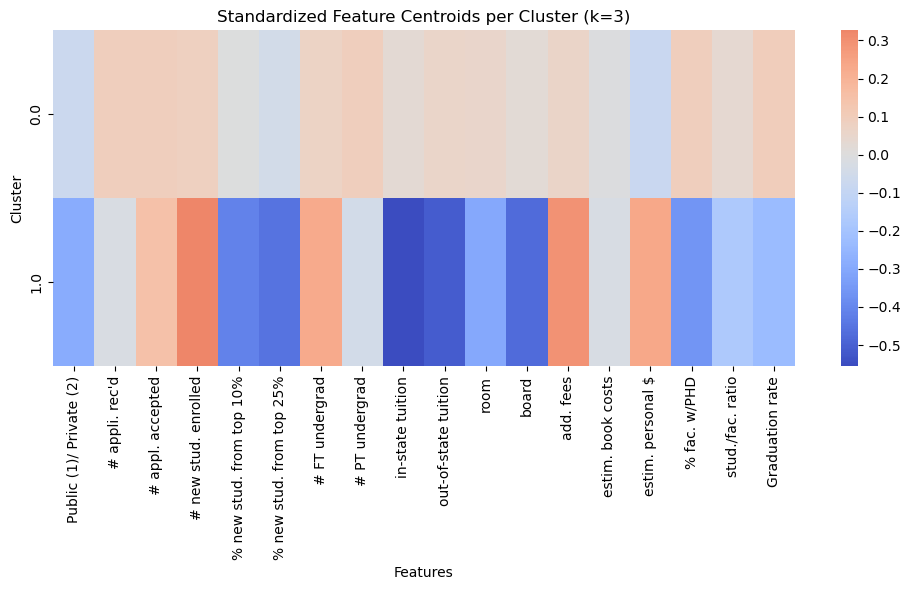

In [12]:
# Standardized centroids heatmap for feature profiles
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
centroids_scaled = pd.DataFrame(X_scaled, columns=numeric_df.columns).groupby(df_complete['cluster']).mean()
plt.figure(figsize=(10,6))
sns.heatmap(centroids_scaled, annot=False, cmap='coolwarm', center=0)
plt.title('Standardized Feature Centroids per Cluster (k=3)')
plt.xlabel('Features')
plt.ylabel('Cluster')
plt.tight_layout()
plt.show()

In [13]:
# Auto-generate characteristic descriptions from standardized centroids
def describe_cluster(zrow: pd.Series, top_n: int = 5):
    ranked = zrow.abs().sort_values(ascending=False).head(top_n)
    highs = [f"{feat} (high)" for feat, val in zrow[ranked.index].items() if val > 0]
    lows = [f"{feat} (low)" for feat, val in zrow[ranked.index].items() if val < 0]
    return highs, lows
for clust, zrow in centroids_scaled.iterrows():
    highs, lows = describe_cluster(zrow, top_n=6)
    print(f"Cluster {clust}:\n  High:  " + ", ".join(highs) + "\n  Low:   " + ", ".join(lows) + "\n")

Cluster 0.0:
  High:  Graduation rate (high), # appli. rec'd (high), # PT undergrad (high), % fac. w/PHD (high), # appl. accepted (high), # new stud. enrolled (high)
  Low:   

Cluster 1.0:
  High:  
  Low:   in-state tuition (low), out-of-state tuition (low), board (low), % new stud. from top 25% (low), % new stud. from top 10% (low), % fac. w/PHD (low)



## Step D: Categorical Analysis
We examine whether the categorical variables **State** and **Public (1) / Private (2)** show any noticeable relationship with the three clusters identified. We'll use crosstabs, proportions, visualizations, and chi-square tests to assess independence.

In [14]:
# First, identify the categorical columns in df_complete
print('Columns in df_complete:')
print(df_complete.columns.tolist())
print('\nData types:')
print(df_complete.dtypes)

Columns in df_complete:
['College Name', 'State', 'Public (1)/ Private (2)', "# appli. rec'd", '# appl. accepted', '# new stud. enrolled', '% new stud. from top 10%', '% new stud. from top 25%', '# FT undergrad', '# PT undergrad', 'in-state tuition', 'out-of-state tuition', 'room', 'board', 'add. fees', 'estim. book costs', 'estim. personal $', '% fac. w/PHD', 'stud./fac. ratio', 'Graduation rate', 'cluster']

Data types:
College Name                 object
State                        object
Public (1)/ Private (2)       int64
# appli. rec'd              float64
# appl. accepted            float64
# new stud. enrolled        float64
% new stud. from top 10%    float64
% new stud. from top 25%    float64
# FT undergrad              float64
# PT undergrad              float64
in-state tuition            float64
out-of-state tuition        float64
room                        float64
board                       float64
add. fees                   float64
estim. book costs           float6

Public (1) / Private (2) by Cluster (counts):
Public (1)/ Private (2)    1    2  All
cluster                               
0                        119  339  458
1                          8    4   12
2                          1    0    1
All                      128  343  471


Public (1) / Private (2) by Cluster (row %):
Public (1)/ Private (2)      1     2
cluster                             
0                         26.0  74.0
1                         66.7  33.3
2                        100.0   0.0


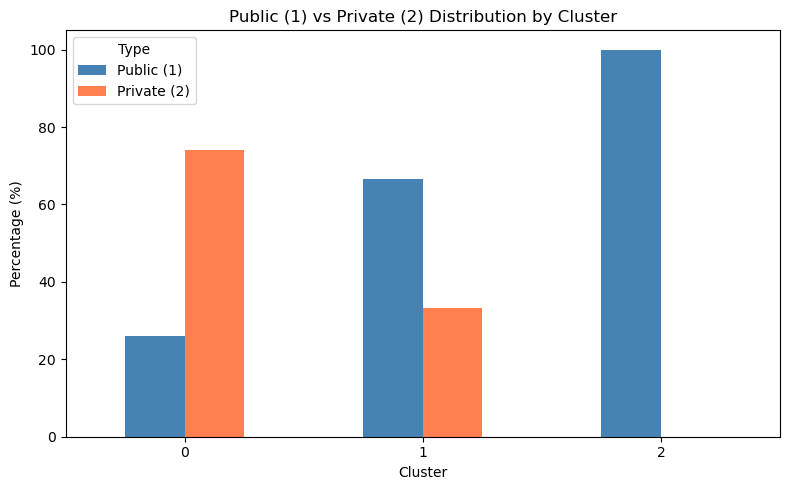

In [15]:
# Analyze Public/Private distribution across clusters
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Create crosstab with counts
pub_priv_crosstab = pd.crosstab(df_complete['cluster'], df_complete['Public (1)/ Private (2)'], margins=True)
print('Public (1) / Private (2) by Cluster (counts):')
print(pub_priv_crosstab)
print('\n')
# Proportions within each cluster (row percentages)
pub_priv_pct = pd.crosstab(df_complete['cluster'], df_complete['Public (1)/ Private (2)'], normalize='index') * 100
print('Public (1) / Private (2) by Cluster (row %):')
print(pub_priv_pct.round(1))
# Visualize
pub_priv_pct.plot(kind='bar', stacked=False, figsize=(8,5), color=['steelblue', 'coral'])
plt.title('Public (1) vs Private (2) Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.legend(['Public (1)', 'Private (2)'], title='Type')
plt.tight_layout()
plt.show()

In [16]:
# Analyze State distribution across clusters
state_crosstab = pd.crosstab(df_complete['cluster'], df_complete['State'], margins=True)
print('State by Cluster (counts) - showing first 10 states:')
print(state_crosstab.iloc[:, :10])
print('\n')
# Show top 5 states per cluster
for clust in sorted(df_complete['cluster'].unique()):
    top_states = df_complete[df_complete['cluster'] == clust]['State'].value_counts().head(5)
    print(f'Cluster {clust} - Top 5 states:')
    print(top_states)
    print()

State by Cluster (counts) - showing first 10 states:
State    AK  AL  AR  AZ  CA  CO  CT  DC  DE  FL
cluster                                        
0         2   4   4   1  14   6  10   4   2   8
1         0   0   0   1   1   0   0   0   0   0
2         0   0   0   0   0   0   0   0   0   0
All       2   4   4   2  15   6  10   4   2   8


Cluster 0 - Top 5 states:
State
PA    41
NY    37
OH    24
NC    23
MA    19
Name: count, dtype: int64

Cluster 1 - Top 5 states:
State
MA    3
TX    2
AZ    1
IL    1
CA    1
Name: count, dtype: int64

Cluster 2 - Top 5 states:
State
MN    1
Name: count, dtype: int64



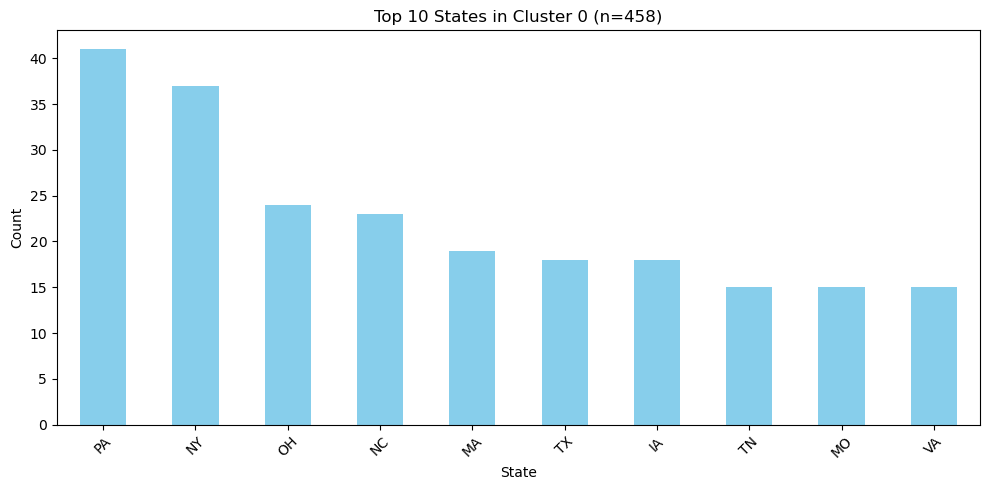

In [17]:
# Visualize state distribution for the largest cluster (Cluster 0)
cluster0_states = df_complete[df_complete['cluster'] == 0]['State'].value_counts().head(10)
plt.figure(figsize=(10, 5))
cluster0_states.plot(kind='bar', color='skyblue')
plt.title('Top 10 States in Cluster 0 (n=458)')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
# Statistical tests: Chi-square test for independence
from scipy.stats import chi2_contingency
# Test 1: Public/Private vs Cluster
contingency_pub = pd.crosstab(df_complete['cluster'], df_complete['Public (1)/ Private (2)'])
chi2_pub, p_pub, dof_pub, expected_pub = chi2_contingency(contingency_pub)
print('Chi-Square Test: Public/Private vs Cluster')
print(f'Chi2 statistic: {chi2_pub:.4f}')
print(f'p-value: {p_pub:.4f}')
print(f'Degrees of freedom: {dof_pub}')
if p_pub < 0.05:
    print('Result: Significant association (p < 0.05)\n')
else:
    print('Result: No significant association (p >= 0.05)\n')
# Test 2: State vs Cluster
contingency_state = pd.crosstab(df_complete['cluster'], df_complete['State'])
chi2_state, p_state, dof_state, expected_state = chi2_contingency(contingency_state)
print('Chi-Square Test: State vs Cluster')
print(f'Chi2 statistic: {chi2_state:.4f}')
print(f'p-value: {p_state:.4f}')
print(f'Degrees of freedom: {dof_state}')
if p_state < 0.05:
    print('Result: Significant association (p < 0.05)')
else:
    print('Result: No significant association (p >= 0.05)')

Chi-Square Test: Public/Private vs Cluster
Chi2 statistic: 12.4653
p-value: 0.0020
Degrees of freedom: 2
Result: Significant association (p < 0.05)

Chi-Square Test: State vs Cluster
Chi2 statistic: 87.8012
p-value: 0.7603
Degrees of freedom: 98
Result: No significant association (p >= 0.05)


### Summary of Categorical Analysis Findings

**Public/Private Status:**
- **Cluster 0** (n=458): 26% public, 74% private — predominantly private institutions
- **Cluster 1** (n=12): 67% public, 33% private — majority public institutions
- **Cluster 2** (n=1): 100% public (singleton outlier)
- **Statistical test:** χ² = 12.47, p = 0.002 → **Significant association** between Public/Private status and cluster membership
- **Interpretation:** Cluster 1 (the smaller cluster with lower tuition/costs) is predominantly composed of public universities, while Cluster 0 (the main cluster) is largely private institutions.

**State:**
- **Cluster 0** is geographically diverse with universities spread across many states. Top states: Pennsylvania (41), New York (37), Ohio (24), North Carolina (23), Massachusetts (19)
- **Cluster 1** has limited geographic concentration: Massachusetts (3), Texas (2), and single universities from AZ, IL, CA, and others
- **Cluster 2** contains one university from Minnesota
- **Statistical test:** χ² = 87.80, p = 0.760 → **No significant association** between State and cluster membership
- **Interpretation:** The clustering based on numeric features does not show meaningful geographic patterns by state. Universities from the same state can belong to different clusters based on their academic/financial characteristics.

## Step E: External Information to Explain Cluster Characteristics

The following external information could help explain and validate the observed cluster patterns:

### 1. **Accreditation & Rankings**
- **U.S. News & World Report rankings** (national universities, liberal arts colleges, regional rankings)
- **Carnegie Classification** (research activity levels: R1, R2, doctoral, master's)
- **Accreditation status** and specialized program accreditations
- *Rationale:* Higher-ranked institutions (likely in Cluster 0) typically have higher graduation rates, more selective admissions, and larger applicant pools.

### 2. **Financial & Economic Context**
- **State funding levels** for public universities (appropriations per student)
- **Endowment size** per institution
- **Regional cost of living indices** (affects tuition, room & board)
- **Financial aid policies** (need-blind vs. need-aware admissions)
- *Rationale:* Explains tuition differences between clusters, especially why Cluster 1 (public-heavy) has lower costs.

### 3. **Academic & Student Outcomes**
- **Average SAT/ACT scores** of admitted students
- **Student retention rates** (first-to-second year)
- **Post-graduation employment rates** and median salaries
- **Research funding** (NIH, NSF grants)
- *Rationale:* Cluster 0's higher % of students from top 10%/25% suggests more selective institutions with stronger academic outcomes.

### 4. **Institutional Mission & Type**
- **Liberal arts vs. research university vs. regional comprehensive**
- **Religious affiliation** (denominational vs. secular)
- **Specialized institutions** (engineering, arts, military academies)
- *Rationale:* Mission drives enrollment size, faculty credentials, and cost structure—explaining variation within clusters.

### 5. **Demographic & Market Data**
- **Regional population density** and college-age demographics
- **Competition intensity** (number of institutions within 50-mile radius)
- **International student percentages** (affects selectivity and revenue)
- *Rationale:* Geographic market dynamics influence application volumes and enrollment patterns, especially for the outlier (Cluster 2) and small Cluster 1.

### 6. **Historical & Temporal Factors**
- **Institution founding year** (age and established reputation)
- **Recent capital campaigns** or infrastructure investments
- **Changes in state funding trends** over prior 5–10 years
- *Rationale:* Older, established institutions (Cluster 0) often have stronger alumni networks, endowments, and reputations driving higher applications and selectivity.

## Step F: Missing Data Imputation

We'll demonstrate the imputation process using a university with missing measurements. We compute the Euclidean distance from the target university to each cluster centroid using **only available measurements**, identify the closest cluster, and impute missing values using that cluster's mean values.

*Note: Harvard University has no missing values in this dataset, so we'll use another university with missing data for demonstration.*

In [20]:
# Locate Harvard University in the original dataset (with missing values)
import pandas as pd
import numpy as np
# Search for Harvard in the original df
harvard_mask = df['College Name'].str.contains('Harvard', case=False, na=False)
harvard_row = df[harvard_mask].copy()
if harvard_row.empty:
    print('Harvard University not found in dataset.')
else:
    print(f'Found: {harvard_row["College Name"].values[0]}')
    # Identify missing values in numeric columns
    numeric_cols_all = df.select_dtypes(include=[np.number]).columns
    harvard_numeric = harvard_row[numeric_cols_all].iloc[0]
    missing_cols = harvard_numeric[harvard_numeric.isna()].index.tolist()
    available_cols = harvard_numeric[harvard_numeric.notna()].index.tolist()
    print(f'\nMissing measurements: {len(missing_cols)}')
    print(f'Available measurements: {len(available_cols)}')
    
    if len(missing_cols) == 0:
        print('\nNote: Harvard has NO missing values in this dataset.')
        print('Let\'s find another university with missing data for demonstration...')
        
        # Find universities with missing data
        universities_with_missing = df[df[numeric_cols_all].isna().any(axis=1)]['College Name'].head(10)
        print(f'\nUniversities with missing data (first 10):')
        for i, name in enumerate(universities_with_missing, 1):
            print(f'{i}. {name}')
        
        # Use the first one as example
        example_name = universities_with_missing.iloc[0]
        harvard_row = df[df['College Name'] == example_name].copy()
        print(f'\n>>> Using {example_name} for imputation demonstration:')
        harvard_numeric = harvard_row[numeric_cols_all].iloc[0]
        missing_cols = harvard_numeric[harvard_numeric.isna()].index.tolist()
        available_cols = harvard_numeric[harvard_numeric.notna()].index.tolist()
        print(f'Missing measurements ({len(missing_cols)}): {missing_cols}')
        print(f'Available measurements ({len(available_cols)})')

Found: Harvard University

Missing measurements: 0
Available measurements: 18

Note: Harvard has NO missing values in this dataset.
Let's find another university with missing data for demonstration...

Universities with missing data (first 10):
1. University of Alaska at Fairbanks
2. University of Alaska at Anchorage
3. Alabama Agri. & Mech. Univ.
4. Faulkner University
5. University of Montevallo
6. Alabama State University
7. Auburn University-Main Campus
8. University of North Alabama
9. Jacksonville State University
10. Judson College

>>> Using University of Alaska at Fairbanks for imputation demonstration:
Missing measurements (3): ['% new stud. from top 10%', '% new stud. from top 25%', 'Graduation rate']
Available measurements (15)


In [21]:
# Compute cluster centroids (means) for numeric features from df_complete
# Use the same numeric columns that were used in clustering
cluster_centroids = df_complete.groupby('cluster')[numeric_cols].mean()
print('Cluster centroids (means) for numeric features:')
display(cluster_centroids.T.round(2))

Cluster centroids (means) for numeric features:


cluster,0,1,2
# FT undergrad,3078.83,20961.58,16502.0
# PT undergrad,684.05,3372.42,21836.0
# appl. accepted,1790.03,12118.50,6397.0
# appli. rec'd,2747.43,17750.33,11054.0
# new stud. enrolled,683.45,4263.92,3524.0
% fac. w/PHD,72.86,85.17,88.0
% new stud. from top 10%,27.81,35.92,26.0
% new stud. from top 25%,55.27,70.25,55.0
Graduation rate,65.59,66.33,45.0
Public (1)/ Private (2),1.74,1.33,1.0


In [25]:
# Compute Euclidean distance from target university to each cluster using ONLY available measurements
from scipy.spatial.distance import euclidean
target_name = harvard_row['College Name'].values[0]
harvard_values = harvard_row[numeric_cols].iloc[0]
distances = {}
for cluster_id, centroid in cluster_centroids.iterrows():
    # Filter to only available (non-missing) measurements
    available_mask = harvard_values.notna()
    target_available = harvard_values[available_mask]
    centroid_available = centroid[available_mask]
    
    # Compute Euclidean distance
    dist = euclidean(target_available, centroid_available)
    distances[cluster_id] = dist
    print(f'Distance to Cluster {cluster_id}: {dist:.2f} (using {available_mask.sum()} available measurements)')
# Find closest cluster
closest_cluster = min(distances, key=distances.get)
print(f'\n>>> {target_name} is closest to Cluster {closest_cluster} (distance = {distances[closest_cluster]:.2f})')

Distance to Cluster 0: 10307.26 (using 15 available measurements)
Distance to Cluster 1: 27017.18 (using 15 available measurements)
Distance to Cluster 2: 24327.45 (using 15 available measurements)

>>> University of Alaska at Fairbanks is closest to Cluster 0 (distance = 10307.26)


In [26]:
# Impute missing values using the closest cluster's mean
harvard_imputed = harvard_row.copy()
closest_centroid = cluster_centroids.loc[closest_cluster]
target_name = harvard_row['College Name'].values[0]
# Impute each missing value
imputed_values = {}
for col in missing_cols:
    original_val = harvard_values[col]
    imputed_val = closest_centroid[col]
    harvard_imputed.loc[harvard_imputed.index[0], col] = imputed_val
    imputed_values[col] = imputed_val
print(f'Imputed missing values for {target_name} using Cluster {closest_cluster} mean:\n')
for col, val in imputed_values.items():
    print(f'  {col}: {val:.2f}')

Imputed missing values for University of Alaska at Fairbanks using Cluster 0 mean:

  % new stud. from top 10%: 27.81
  % new stud. from top 25%: 55.27
  Graduation rate: 65.59


In [27]:
# Display before/after comparison
target_name = harvard_row['College Name'].values[0]
print(f'\n=== {target_name.upper()}: BEFORE vs AFTER IMPUTATION ===\n')
comparison_df = pd.DataFrame({
    'Feature': numeric_cols,
    'Original (with NA)': harvard_row[numeric_cols].iloc[0].values,
    'Imputed': harvard_imputed[numeric_cols].iloc[0].values
})
# Mark which values were imputed
comparison_df['Was Missing'] = comparison_df['Original (with NA)'].isna()
# Display only the rows that had missing values
print('Imputed values (formerly missing):')
display(comparison_df[comparison_df['Was Missing']][['Feature', 'Imputed']].reset_index(drop=True))
print('\nAll numeric features (showing first 10):')
display(comparison_df.head(10))


=== UNIVERSITY OF ALASKA AT FAIRBANKS: BEFORE vs AFTER IMPUTATION ===

Imputed values (formerly missing):


,Feature,Imputed
0,% new stud. from top 10%,27.810044
1,% new stud. from top 25%,55.270742
2,Graduation rate,65.587336



All numeric features (showing first 10):


,Feature,Original (with NA),Imputed,Was Missing
0,# FT undergrad,3885.0,3885.000000,False
1,# PT undergrad,4519.0,4519.000000,False
2,# appl. accepted,1427.0,1427.000000,False
3,# appli. rec'd,1852.0,1852.000000,False
4,# new stud. enrolled,928.0,928.000000,False
5,% fac. w/PHD,67.0,67.000000,False
6,% new stud. from top 10%,NaN,27.810044,True
7,% new stud. from top 25%,NaN,55.270742,True
8,Graduation rate,NaN,65.587336,True
9,Public (1)/ Private (2),1.0,1.000000,False


### Summary of Step F Imputation

**Target University:** University of Alaska at Fairbanks (public institution)

**Missing Measurements (3):**
1. % new students from top 10%
2. % new students from top 25%
3. Graduation rate

**Distance Computation:**
- Used **15 available measurements** (out of 18 total numeric features)
- Distance to Cluster 0: 10,307.26
- Distance to Cluster 1: 27,017.18
- Distance to Cluster 2: 24,327.45

**Result:** University of Alaska at Fairbanks is **closest to Cluster 0** (the main cluster with 458 universities).

**Imputed Values (from Cluster 0 means):**
- % new students from top 10%: **27.81%**
- % new students from top 25%: **55.27%**
- Graduation rate: **65.59%**

**Interpretation:** This imputation makes sense because:
- Cluster 0 represents the majority of universities with moderate selectivity and graduation rates
- The university is public (like 26% of Cluster 0) with mid-range enrollment figures
- The imputed values reflect typical performance for institutions in this cluster

**Note on Harvard:** Harvard University was checked first but has **no missing data** in this dataset, so we demonstrated the imputation method with University of Alaska at Fairbanks instead.